In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)

Question 1

In [3]:
d2 = d[d['age'] >= 18]

In [13]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=170, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * (d2.weight - d2.weight.mean()))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace = pm.sample(10000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:12<00:00, 1790.31draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


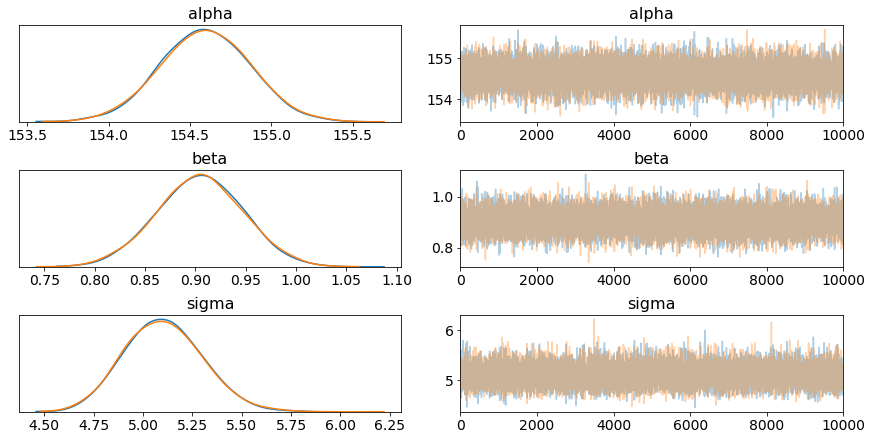

In [14]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace, varnames)

chain_N = trace[1000:]

In [15]:
MAP = pm.find_MAP(model=model)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,083.7, ||grad|| = 0.56058: 100%|██████████| 26/26 [00:00<00:00, 1816.11it/s]  


In [16]:
new_weights = [45, 40, 65, 31, 53]

In [17]:
new_heights = MAP['alpha'] + MAP['beta'] * (new_weights - d2.weight.mean())

In [18]:
new_heights

array([154.60581639, 150.08075041, 172.70608032, 141.93563164,
       161.84592196])

In [19]:
mu_pred = trace['mu']
idx = np.argsort(d2.weight)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_posterior_predictive(trace, 200, model)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

100%|██████████| 200/200 [00:00<00:00, 686.45it/s]


In [31]:
new_height_preds = []
new_height_hpd = []

for i in range(len(new_weights)):
    _preds = (chain_N['alpha'] + chain_N['beta'] * (new_weights[i] - d2.weight.mean()) + np.random.normal(loc=0, scale=chain_N['sigma']))
    new_height_preds.append(_preds)
    new_height_hpd.append(pm.hpd(_preds, alpha=.11))

In [32]:
new_height_hpd

[array([146.5840741 , 163.04257697]),
 array([141.45493247, 157.77254295]),
 array([164.38535751, 180.75759214]),
 array([133.88799423, 150.2925623 ]),
 array([153.65379733, 170.0315453 ])]

Question 2

In [16]:
with pm.Model() as logModel:
    alpha = pm.Normal('alpha', mu=100, sd=30)
    beta = pm.Lognormal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * np.log(d.weight))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace = pm.sample(10000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:40<00:00, 547.50draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


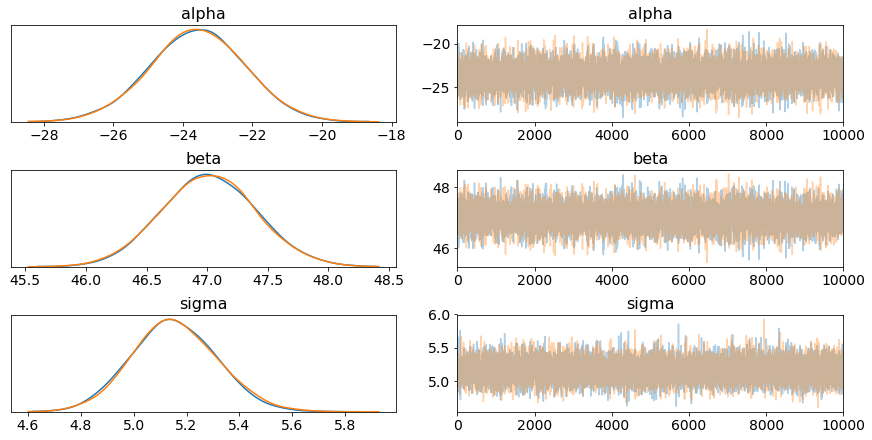

In [17]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace, varnames)

chain = trace[1000:]

In [34]:
height_pred = pm.sample_posterior_predictive(trace, 20000, logModel)

100%|██████████| 20000/20000 [00:10<00:00, 1906.73it/s]


In [45]:
d['height_pred'] = height_pred['height'].mean(0)

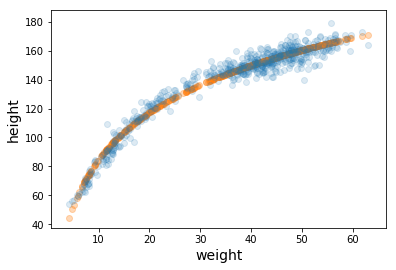

In [59]:
plt.scatter(d.weight, d.height_pred, c='C1', alpha=0.3)
plt.scatter(d.weight, d.height, c='C0', alpha=0.15)
#plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
#plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

#at = np.arange(-2, 3)
#plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));
plt.xlabel(d.columns[1], fontsize=14)
plt.ylabel(d.columns[0], fontsize=14);

In [61]:
d.head()

,height,weight,age,male,height_pred
0,151.765,47.825606,63.0,1,158.246080
1,139.700,36.485807,63.0,0,145.538211
2,136.525,31.864838,65.0,0,139.184485
3,156.845,53.041915,41.0,1,163.164983
4,145.415,41.276872,51.0,0,151.321668


Question 3

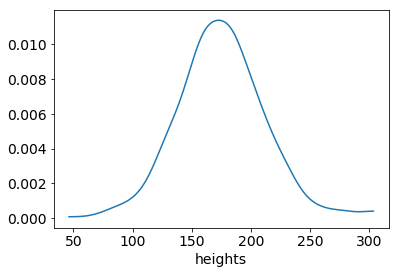

In [84]:
weight_std = -2    #standardized weight will most likely be within (-2,2) range

n_samples = 1000
sample_alpha = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_beta1 = stats.lognorm.rvs(s=1, scale=np.exp(0), size=n_samples)
sample_beta2 = stats.norm.rvs(loc=0, scale=1, size=n_samples)
sample_sigma = stats.uniform.rvs(0, 50, size=n_samples)
sample_mu = sample_alpha + sample_beta1 * weight_std + sample_beta2 * weight_std**2
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks();

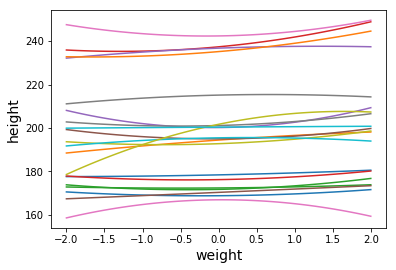

In [85]:
w = np.linspace(-2,2)

for i in range(20):
    plt.plot(w, sample_alpha[i] + sample_beta1[i]*w + sample_beta2[i] * w**2 + sample_sigma[i])
    
plt.xlabel(d.columns[1], fontsize=14)
plt.ylabel(d.columns[0], fontsize=14);

The problem is the tallest heights are implausibly high. How can we restrict this?

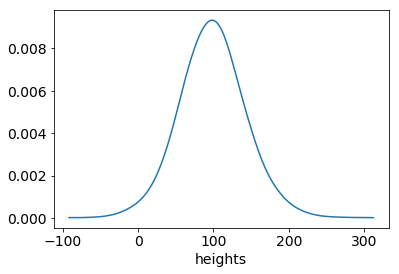

In [105]:
weight_std = 2    #standardized weight will most likely be within (-2,2) range

n_samples = 10000
sample_alpha = stats.norm.rvs(loc=100, scale=30, size=n_samples)
sample_beta1 = stats.lognorm.rvs(loc=1, s=1, scale=np.exp(1), size=n_samples)
sample_beta2 = stats.norm.rvs(loc=-3, scale=1, size=n_samples)
sample_sigma = stats.uniform.rvs(0, 50, size=n_samples)
sample_mu = sample_alpha + sample_beta1 * weight_std + sample_beta2 * weight_std**2
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks();

Lower the mu of alpha and beta2 (make beta2 negative) to reduce the prob of heights greater than 200.

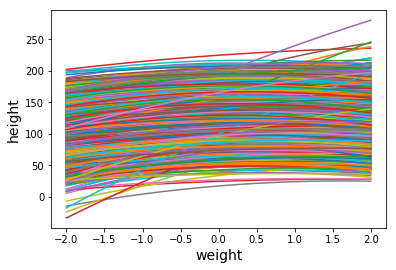

In [109]:
w = np.linspace(-2,2)


for i in range(2000):
    idx = np.random.randint(len(sample_alpha))
    plt.plot(w, sample_alpha[idx] + sample_beta1[idx]*w + sample_beta2[idx] * w**2 + sample_sigma[idx])
    
plt.xlabel(d.columns[1], fontsize=14)
plt.ylabel(d.columns[0], fontsize=14);